# 1. Import Dependencies

In [1]:
# -----------------External Import-----------------
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_huggingface import ChatHuggingFace
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage
import json
import random
from typing import Literal

# -----------------Internal Import-----------------
from generation_agent import get_hugface_model
from transcript_agent import VoiceToText
from video_agent import SmolVLM2ChatModel
from memory import MemoryManager
from tools import generate_report, clean_think_blocks, extract_assistant_response
from prompt_template import supervisor_system_prompt_3, report_system_prompt_1

# 2. Design Langgraph Node Logic

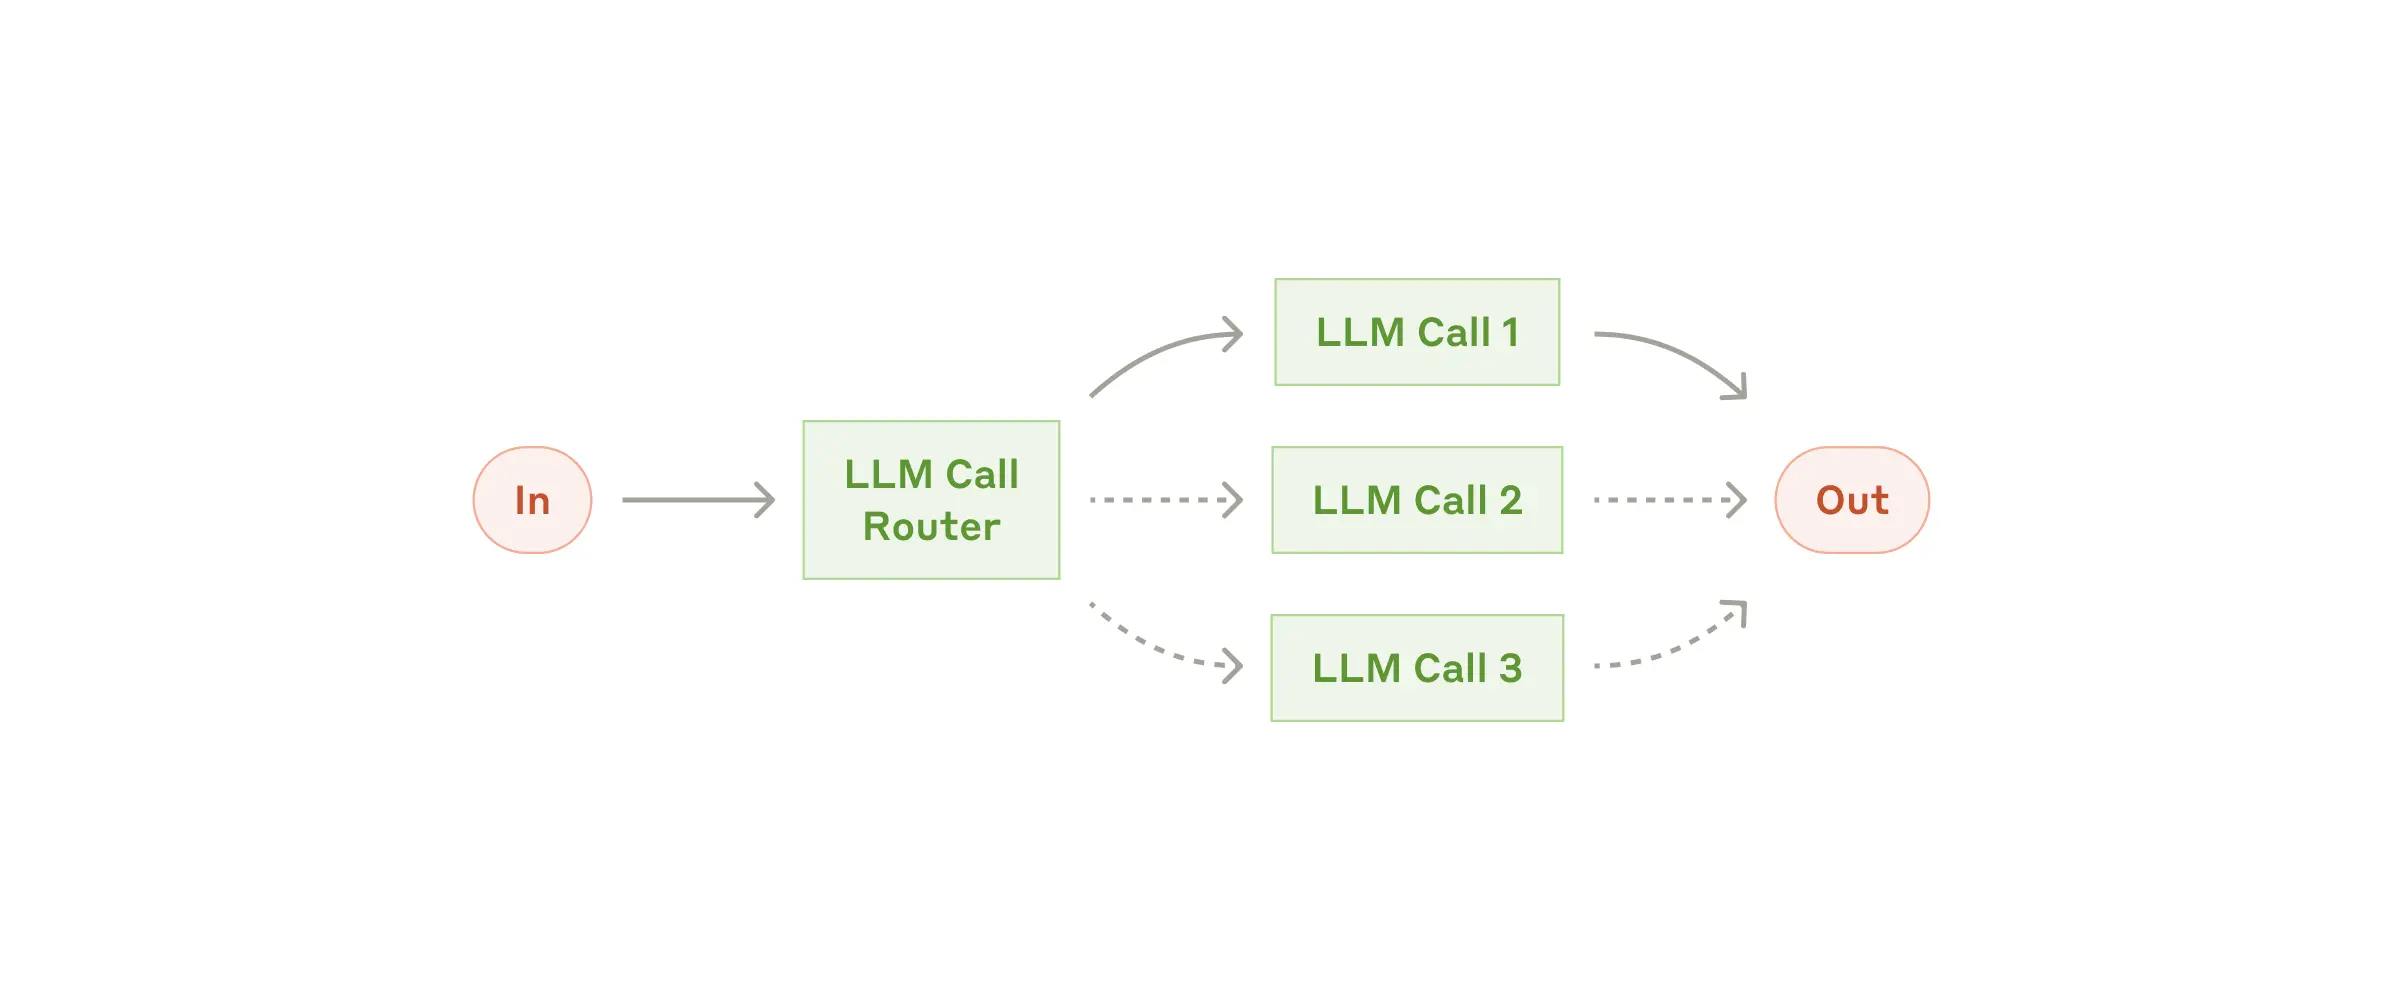

## 2.1 Define the Graph State

In [7]:
# Define a state that inherit from 'MessagesState', 'MessagesState' has a key value called "messages" that can store a list of message conversation
class GraphState(MessagesState):
    user_id: str
    session_id: str
    user_query: str
    video_path: str
    final_response: str
    report_path: str
    chat_history: str

    hug_llm: ChatHuggingFace
    transcript_model: VoiceToText
    vlm: SmolVLM2ChatModel
    memory: MemoryManager

    orchestrator_msg: str


## 2.2 Define Node Logic

In [8]:
def load_memory(state: GraphState):
    print("--------------- Entering: load_memory ---------------")
    # Validate state
    if state.get("memory") is None or state.get("user_id") is None or state.get("session_id") is None:
        raise KeyError("No key 'memory' or key 'user_id' or key 'session_id' is available in graph state.")
    
    # Get the memory, user_id, session_id
    memory = state["memory"]
    user_id = state["user_id"]
    session_id = state["session_id"]

    # Create a chat session in persistance memory, if the chat session exist, it will ignore and do nothing
    memory.add_chat_session(
        user_id=user_id,
        session_id=session_id
    )

    # Load the chat history
    chat_history = memory.get_context(
        user_id=user_id,
        session_id=session_id,
        top_k=8    
    )
    print(f"-----Chat History-----")
    print(f"{chat_history}")
    print(f"----------------------")

    return{
        "chat_history": chat_history
    }





In [9]:
def orchestrator(state: GraphState):
    print("--------------- Entering: orchestrator ---------------")
    user_query = state["user_query"]
    llm_model = state["hug_llm"]

    messages = [
        SystemMessage(content=supervisor_system_prompt_3),
        HumanMessage(content=user_query),
    ]

    # Step 5 — Call your agent
    response = llm_model.invoke(messages)

    ai_msg = clean_think_blocks(response.content)

    print(ai_msg)

    return{
        "final_response": ai_msg,
        "orchestrator_msg": ai_msg
    }

In [10]:
def orchestrator_route(state: GraphState) -> Literal["video_analyst", "transcript_analyst", "report_analyst", "end"]:
    
    # Often, we will use state to decide on the next node to visit
    orchestrator_msg = state['orchestrator_msg'] 

    try:
        json_data = json.loads(orchestrator_msg)
        if json_data:
            task_name = json_data["Task_name"]
            agent_name = json_data["agent_name"]

            if task_name == "video_analysis" or agent_name =="video_analyst":
                return "video_analyst"
            
            elif task_name == "transcript_analysis" or agent_name =="transcript_analyst":
                return "transcript_analyst"
        
            elif task_name == "report_generation" or agent_name =="report_analyst":
                return "report_analyst"
            else:
                return "end"
            
        else:
            return "end"
    except:
        return "end"



In [11]:
def transcript_agent(state: GraphState):
    print("--------------- Entering: transcript agent ---------------")

    video_path = state["video_path"]
    transcript_model = state["transcript_model"]

    ai_responses = [
        "✅ Got it! Here's what I came up with: 👇\n{text}",
        "💡 Sure thing! Take a look at this: 👇\n{text}",
        "👍 No worries — here’s my response: 👇\n{text}",
        "✨ Here’s what I’ve prepared for you: 👇\n{text}",
        "🤖 Absolutely! Here’s the result: 👇\n{text}",
        "👌 Sure! This is what I found: 👇\n{text}",
        "🚀 Done! Here’s my output: 👇\n{text}",
        "🧠 Here’s my take on that: 👇\n{text}",
        "📘 Here’s the information you asked for: 👇\n{text}",
        "✅ All set! Check out my answer below: 👇\n{text}",
    ]

    # Example usage:
    # text = "A large language model is an AI trained on massive amounts of text data."
    # ai_response = random.choice(ai_responses).format(text=text)


    try:
        text = transcript_model.transcribe(video_path) 
        print("Transcription:", text)
        ai_response = random.choice(ai_responses).format(text=text)
    except Exception as e:
        print(f"Error message: {e}")
        ai_response = "🤒 Sorry, I cannot fullfill your request, a thousand apologies. 👏👏👏"

    return {
        "final_response": ai_response
    }


    

In [12]:
def video_agent(state: GraphState):
    print("--------------- Entering: video agent ---------------")
    video_path = state["video_path"]
    smolvlm2 = state["vlm"]
    user_query = state["user_query"]

    ai_responses = [
        "✅ Got it! Here's what I came up with: 👇\n{text}",
        "💡 Sure thing! Take a look at this: 👇\n{text}",
        "👍 No worries — here’s my response: 👇\n{text}",
        "✨ Here’s what I’ve prepared for you: 👇\n{text}",
        "🤖 Absolutely! Here’s the result: 👇\n{text}",
        "👌 Sure! This is what I found: 👇\n{text}",
        "🚀 Done! Here’s my output: 👇\n{text}",
        "🧠 Here’s my take on that: 👇\n{text}",
        "📘 Here’s the information you asked for: 👇\n{text}",
        "✅ All set! Check out my answer below: 👇\n{text}",
    ]

    # Example usage:
    # text = "A large language model is an AI trained on massive amounts of text data."
    # ai_response = random.choice(ai_responses).format(text=text)

    
    try:
        response = smolvlm2.invoke({
            "role": "user",
            "content": [
                {"type": "video", "path": video_path},
                {"type": "text", "text": user_query}
            ]}
        )
        ai_msg = extract_assistant_response(response["content"])
        print(f"{ai_msg}")
        ai_response = random.choice(ai_responses).format(text=ai_msg)

    except Exception as e:
        print(f"Error message: {e}")
        ai_response = "🤒 Sorry, I cannot fullfill your request, a thousand apologies. 👏👏👏"

    return {
        "final_response": ai_response
    }

In [13]:
def report_agent(state: GraphState):
    print("--------------- Entering: report agent ---------------")

    memory = state["memory"]
    user_id = state["user_id"]
    session_id = state["session_id"]
    user_query = state["user_query"]
    llm_model = state["hug_llm"]

    success_responses = [
        "✨ Sure! Your request has been completed successfully ✅",
        "✅ Done! Everything went smoothly ✨",
        "🎯 Request processed successfully — all set!",
        "👍 Got it! Your request was handled perfectly ✅",
        "🚀 Success! The task is now complete ✨",
        "🌟 All done — your request went through successfully ✅",
        "💪 Mission accomplished! Everything’s done as requested ✨",
        "🧩 Your request was processed with no issues ✅",
        "🎉 Great! Everything has been completed successfully ✨",
        "✅ All set! Your request finished without any errors 🌟",
    ]

    # Example usage:
    # ai_response = random.choice(success_responses)
    # print(ai_response)

    # Load the chat history
    chat_history = memory.get_context(
        user_id=user_id,
        session_id=session_id,
        top_k=8    
    )

    user_query_with_history = f"""
    Based on our chat history:
    {chat_history}
    {user_query}
    """

    messages = [
        SystemMessage(content=report_system_prompt_1),
        HumanMessage(content=user_query_with_history),
    ]

    # Step 5 — Call your agent
    response = llm_model.invoke(messages)
    ai_msg = response.content
    ai_msg = clean_think_blocks(text=ai_msg)
    print(ai_msg)

    try:
        function_call = json.loads(ai_msg)

        report_file_path = generate_report(function_call["args"])
        ai_response = random.choice(success_responses)
    except Exception as e:
        ai_response = "🤒 Sorry, I cannot fullfill your request, a thousand apologies. 👏👏👏"
        report_file_path = "NA"


    return{
        "report_path": report_file_path,
        "final_response": ai_response
    }

In [14]:
def update_memory(state: GraphState):
    print("--------------- Entering: Update Memory ---------------")
    
    # Get the memory, user_id, session_id
    memory = state["memory"]
    user_id = state["user_id"]
    session_id = state["session_id"]
    user_query = state["user_query"]
    final_response = state["final_response"]

    memory.add_message(user_id, session_id, "Human", user_query)
    memory.add_message(user_id, session_id, "AI", final_response)

    # Load the chat history
    chat_history = memory.get_context(
        user_id=user_id,
        session_id=session_id,
        top_k=8    
    )
    print(f"-----Chat History-----")
    print(f"{chat_history}")
    print(f"----------------------")




# 3. Compile the Graph

## 3.1 Define Compile Logic

In [15]:
def build_graph() -> StateGraph:
    workflow = StateGraph(GraphState)

    # Add Node logic
    workflow.add_node("load_memory", load_memory)
    workflow.add_node("orchestrator", orchestrator)
    workflow.add_node("transcript_agent", transcript_agent)
    workflow.add_node("video_agent", video_agent)
    workflow.add_node("report_agent", report_agent)
    workflow.add_node("update_memory", update_memory)

    

    workflow.add_edge(START, "load_memory")
    workflow.add_edge("load_memory", "orchestrator")
    workflow.add_conditional_edges(
        source="orchestrator",
        path=orchestrator_route,
        path_map={
            "transcript_analyst": "transcript_agent",
            "video_analyst": "video_agent",
            "report_analyst": "report_agent",
            "end": "update_memory"
        }
    )
    workflow.add_edge("transcript_agent", "update_memory")
    workflow.add_edge("video_agent", "update_memory")
    workflow.add_edge("report_agent", "update_memory")


    workflow = workflow.compile()

    return workflow

    

In [16]:
ai_workflow = build_graph()

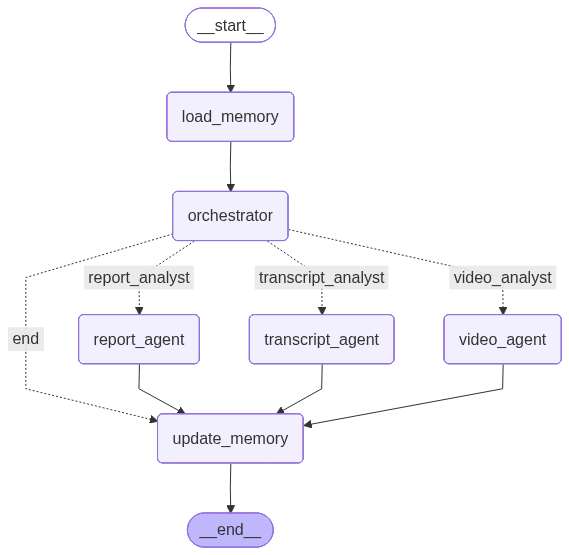

In [17]:
from IPython.display import Image, display

# View
display(Image(ai_workflow.get_graph().draw_mermaid_png()))

## 3.2 Test the AI Workflow

In [18]:
'''
# Define a state that inherit from 'MessagesState', 'MessagesState' has a key value called "messages" that can store a list of message conversation
class GraphState(MessagesState):
    user_id: str
    session_id: str
    user_query: str
    video_path: str
    final_response: str
    report_path: str
    chat_history: str

    hug_llm: ChatHuggingFace
    transcript_model: VoiceToText
    vlm: SmolVLM2ChatModel
    memory: MemoryManager
'''

# Prepare Models and memory
hug_llm = get_hugface_model()
transcript_model = VoiceToText()
vlm = SmolVLM2ChatModel(model_size="medium", quantization="4bit")

memory = MemoryManager(
    persist=True,
    filename="memory_store.pkl"
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Setting the `device` argument to None from -1 to avoid the error caused by attempting to move the model that was already loaded on the GPU using the Accelerate module to the same or another device.
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🔹 Loading Whisper model: openai/whisper-tiny
📂 Model cache directory: c:\Interview Assignment\Intel GenAI Software Engineer Assessment\Short-Video-Analyst\model\openai-whisper-tiny
✅ Whisper model loaded successfully on cuda
🔹 Preparing to load HuggingFaceTB/SmolVLM2-500M-Instruct (medium) with 4bit quantization...
📂 Model cache directory: c:\Interview Assignment\Intel GenAI Software Engineer Assessment\Short-Video-Analyst\model\SmolVLM2-500M-Instruct
⚙️ Using bitsandbytes 4bit quantization.
🚀 Loading model weights into cuda...


`torch_dtype` is deprecated! Use `dtype` instead!


✅ Successfully loaded MEDIUM SmolVLM2 model (cuda)!


In [27]:
user_id = "user1"
session_id =  "session1"

# Soccer Goal
#user_query = "Can you transcribe this video, analyse the video content and then summarize everything into a pdf?"
#user_query = "Can you transcribe this video first?"
#user_query = "Can you tell me what you see in this video, what kind of event is happening ?"

#video_path= r"C:\Interview Assignment\Intel GenAI Software Engineer Assessment\Short-Video-Analyst\sample_videos\Son strikes first 🚀.mp4"

#user_query = "Can you transcribe this video, analyse the video content and then summarize everything into a pdf?"
#user_query = "ok, lets start with transcribe the video first"
#user_query = "okok, Can you tell me what you see in this video, what kind of event is happening ?"
user_query = "ok thank you for your video analysis, lets end it with a pptx summary shall we ?"
video_path = r"C:\Interview Assignment\Intel GenAI Software Engineer Assessment\Short-Video-Analyst\sample_videos\cat.mp4"


workflow_state = {
    "user_id": user_id,
    "session_id": session_id,
    "user_query": user_query,
    "video_path": video_path,

    "hug_llm": hug_llm,
    "transcript_model": transcript_model,
    "vlm": vlm,
    "memory": memory
}


response_data = ai_workflow.invoke(
    workflow_state
)


--------------- Entering: load_memory ---------------
-----Chat History-----
Human: Can you summarise our discussion into a powerpoint slide?
AI: 🎉 Great! Everything has been completed successfully ✨
Human: Can you transcribe this video, analyse the video content and then summarize everything into a pdf?
AI: Hi, please have mercy on me 🥲. You’re giving me too many tasks! I’m just a small local model and can only handle one task at a time 👏👏👏.
Human: ok, lets start with transcribe the video first
AI: 🤒 Sorry, I cannot fullfill your request, a thousand apologies. 👏👏👏
Human: okok, Can you tell me what you see in this video, what kind of event is happening ?
AI: ✅ Got it! Here's what I came up with: 👇
The video captures a moment of domestic tranquility, where a cat is the central figure. The cat, with its fur in shades of white and brown, is seen sitting on a tiled floor. Its head is turned to the side, as if it's observing its surroundings. The cat's expression is neutral, adding to the c

In [28]:
final_response = response_data["final_response"]
print(final_response)

💪 Mission accomplished! Everything’s done as requested ✨


In [29]:
response_data["report_path"]

'c:\\Interview Assignment\\Intel GenAI Software Engineer Assessment\\Short-Video-Analyst\\agents\\report\\video_analysis_pptx.pptx.pptx'